# HOUSE PRICE PREDICTION
## INTRODUCTION
In questo tutorial vediamo come affrontare il problema della predizione del prezzo delle case partendo da un dataset che ha molte features al suo interno e in particolare, le colonne del dataset rappresentano eìle feeatures mentre le righe rappresentano il numero di case di cui abbiamo i dati.


- Iniziamo importando le librerie necessarie per affrontare questo problema di regressione.

In [1]:
# Librerie per analisi del dataset 
import pandas as pd
import numpy as np 

#data visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

# per l'analisi del dataset 
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statistics import mean

# per il  machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.cluster import AgglomerativeClustering
# per la spiegazione dei dati



Il dataset originale descrive ogni casa con 81 features ma per semplicità noi andiamo a prendere solo 12 features, inoltre all'interno del dataset ci sono molte variabili che sono categoriche o ___NaN___


In [2]:
# per esempio facciamo vedere quali sono tutte le colonne che compongono il df
df_complete = pd.read_csv("train.csv")
df_complete.head()
# opzioni per il plot
palette = "viridis"
plt.rcParams['figure.figsize'] = [10, 5]

Selezioniamo quindi solo le 12 colonne di nostro interesse. Per comprendere cosa sono queste features, il dataset che abbiamo scaricato da kaggle, ha un file al suo interno che si chiama _datadescription.txt_ utile proprio alla descrizione dell'intero dataset


In [3]:

cols = ["Id","OverallQual","GrLivArea","GarageCars", 
        "GarageArea","TotalBsmtSF","FullBath",
        "YearBuilt","YearRemodAdd",
        "LotFrontage","MSSubClass", "SalePrice"]

df_sliced = df_complete[cols]
df_sliced.head()


,Id,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
0,1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
1,2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
2,3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
3,4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
4,5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


## DATA ANALYSIS
Il primo passo quando ci troviamo difronte un nuovo dataset è quello di effettuare un' analisi esplorativa. Possiamo infatti suddividere l'intero lavoro di esplorazione in differenti step:
- Analisi delle variabili che si trovano all'interno del dataset(Categoriche, NaN)


In [4]:
#scrivo una funzione utile categorizzazione delle variabili 
def rec_type(dtf, col, max_types):
    if (dtf[col].dtype == "0") | (dtf[col].nunique() < max_types):
        return "cat"
    else:
        return "num"

#utilizziamo questa funzione per plottare una heatmap

dict_cols = {col:rec_type(df_sliced, col, max_types=20) for col in df_sliced.columns}


il dizionario che abbiamo definito in alto ci permette di capire quali colonne sono categoriche e quali colonne sono numeriche infatti esso restituisce in output la descrizione delle colonne nella forma col:"num" o col:"cat".

 Categorical   Numeric   NaN 


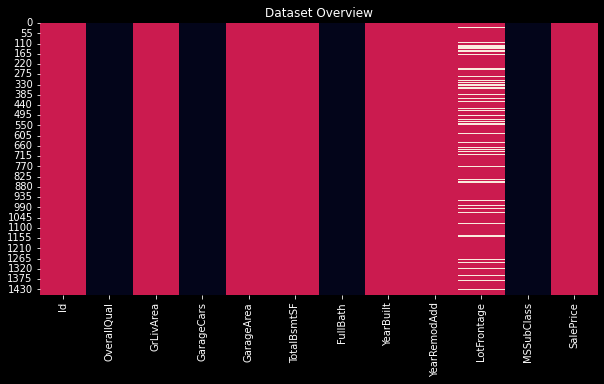

In [5]:
heatmap = df_sliced.isnull()
for k,v in dict_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
plt.style.use("dark_background")
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
print("\033[1;37;48m Categorical ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")
plt.show()


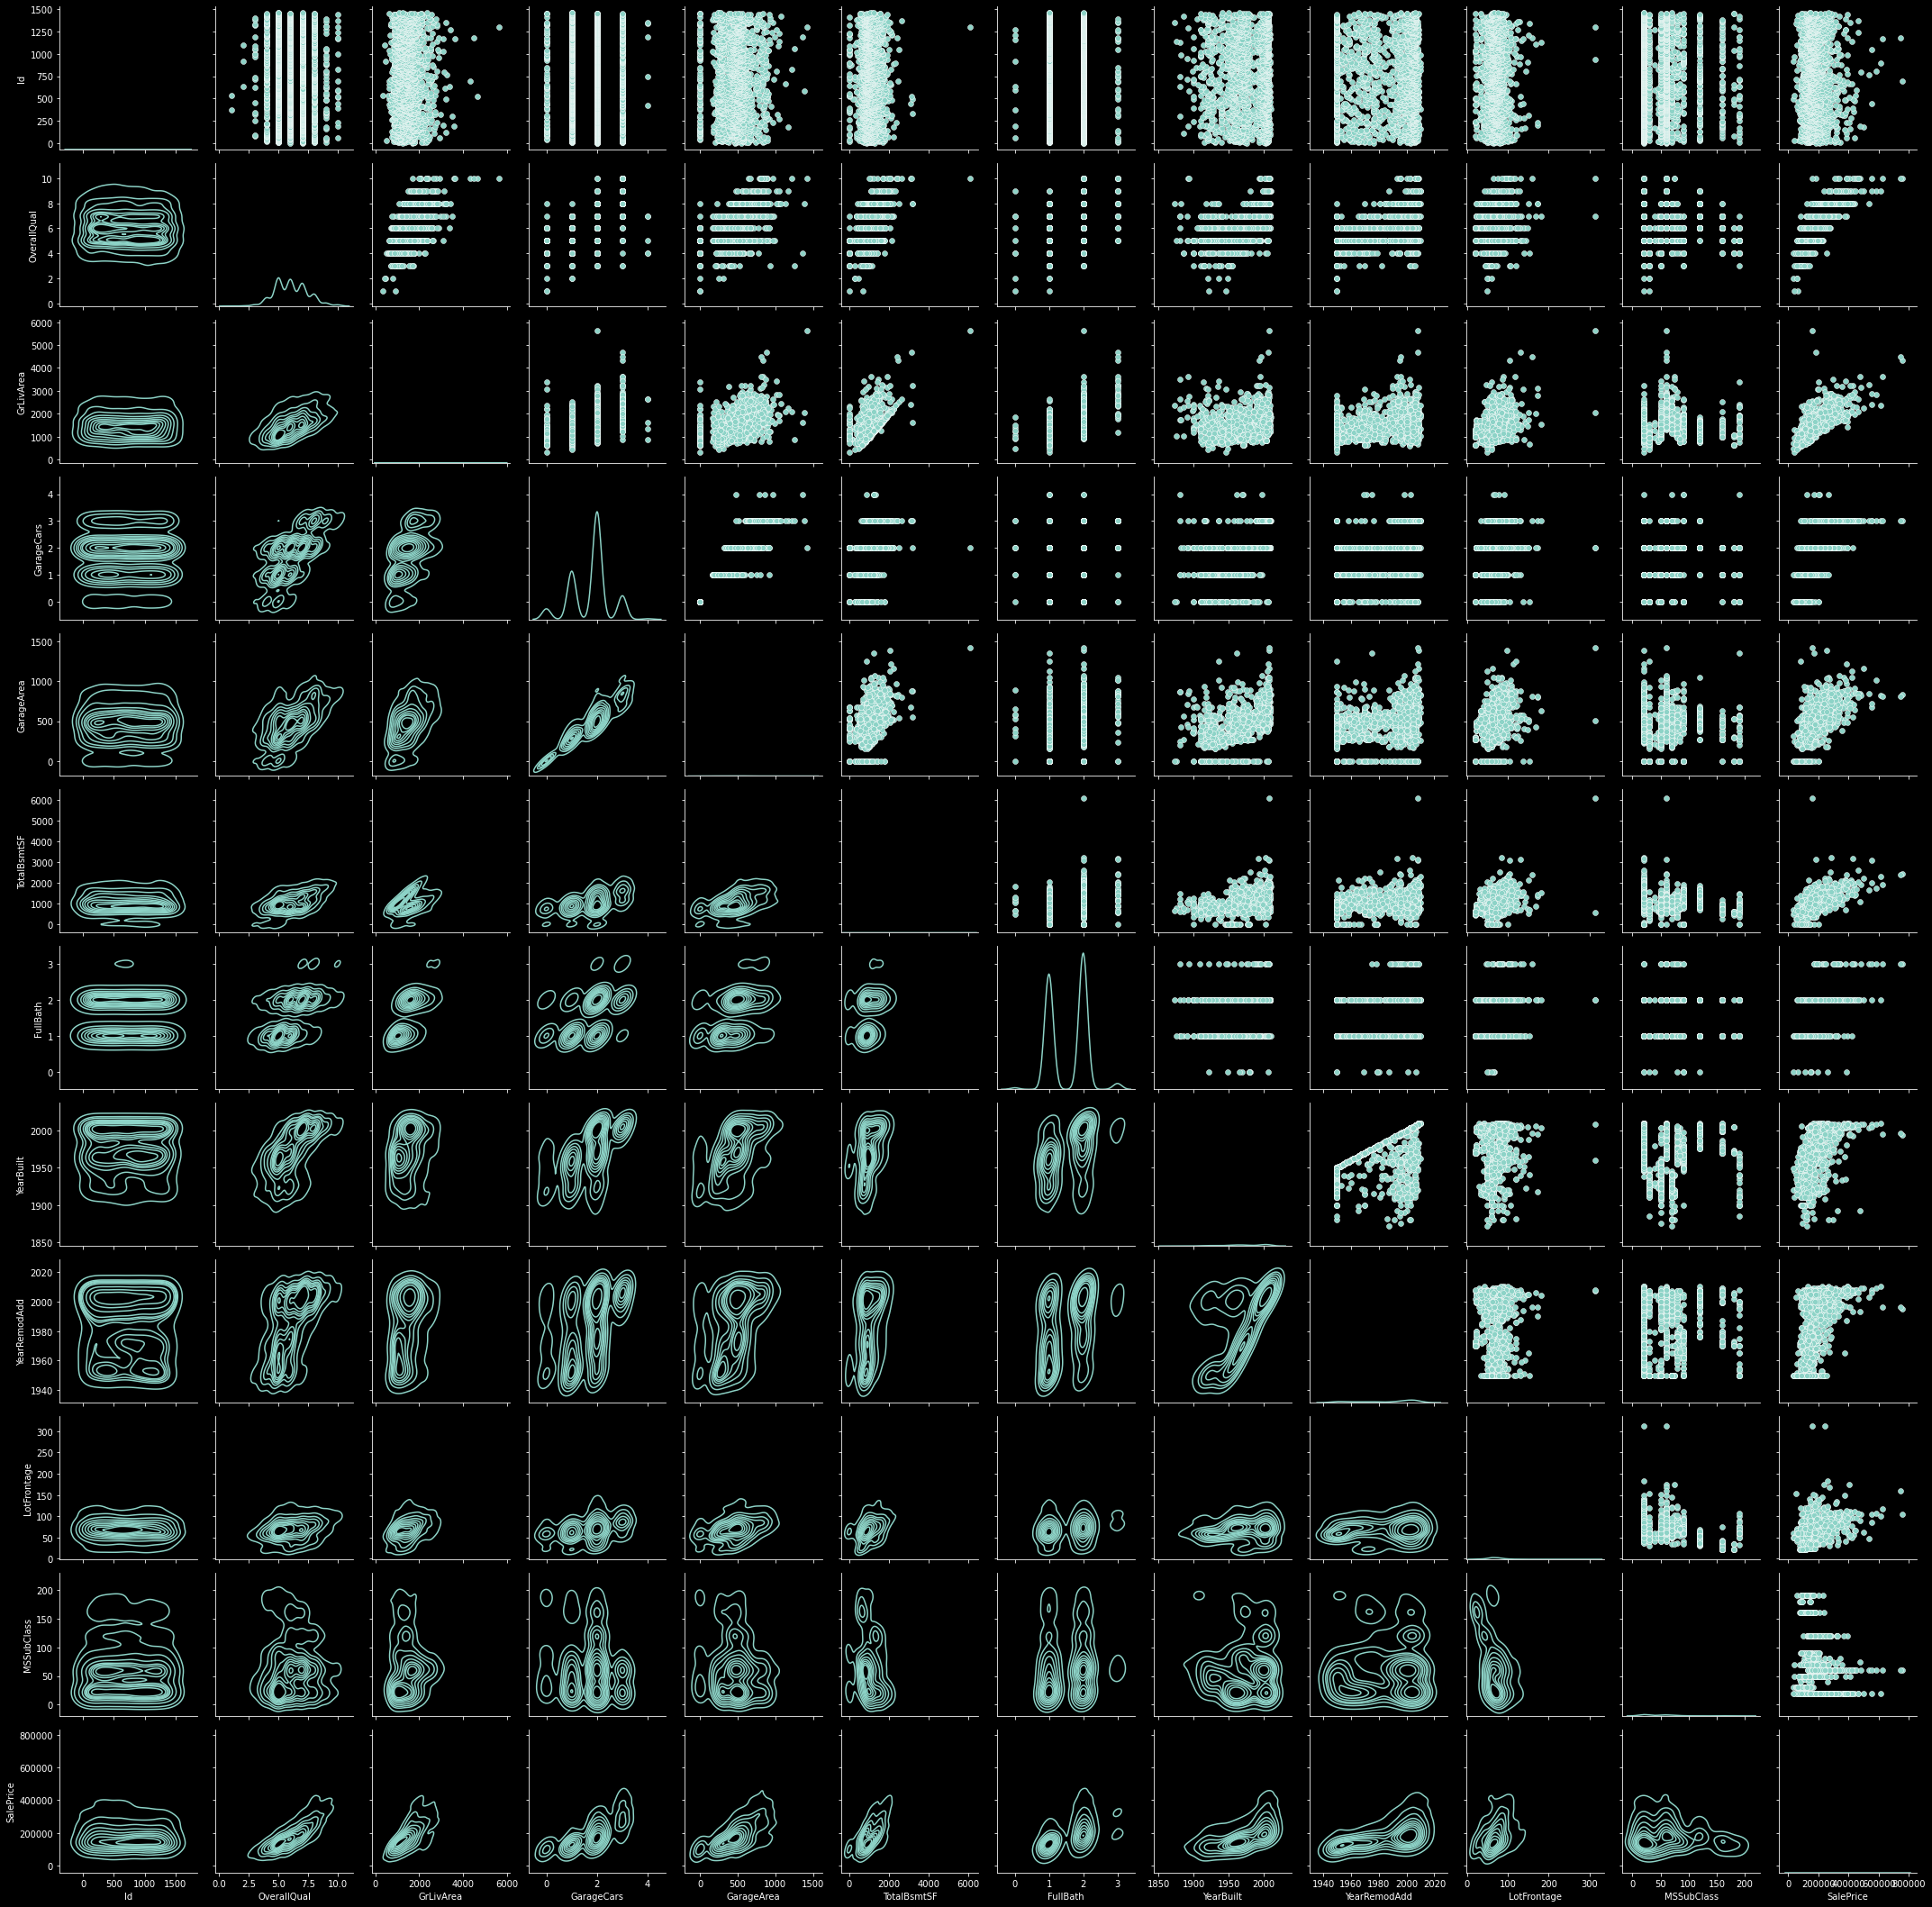

In [6]:
plt.style.use("dark_background")
g = sns.PairGrid(df_sliced)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)


Dall'analisi che abbiamo fatto sopra possiamo dure che la variabile LotFrontage contiene dei missing data, e inoltre abbiamo capito quali sono le variabili categoriche e quali sono le variabili numeriche.
La nostra regressione deve essere messa nella forma:

$SalePrice = [w][var]$
Poichè noi vogliamo predirre il prezzo delle case, avremo un vettore dei pesi w che moltiplicato per le nostre variabili ci darà la regressione che ci pernmettrà di capire e predirre anche il prezzo di case di cui non abbiamo dati.

In [7]:
df_sliced = df_sliced.set_index("Id")
df_sliced = df_sliced.rename(columns={"SalePrice":"Y"})
df_sliced.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,Y
Id,,,,,,,,,,,
1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


Il box plot ci può essere molto utile per andare a capire la distribuzione e quali sono gli outliers del nostro dataset. Altro plot di estrema importanza è la distribuzione univariata, plotatta sotto la forma di istogramma o kde function. Per cui nella sezione in basso andiamo ad analizzare a titolo di esempio solo la distribuzione e il box plot della nostra variabile ___SalesPrice___

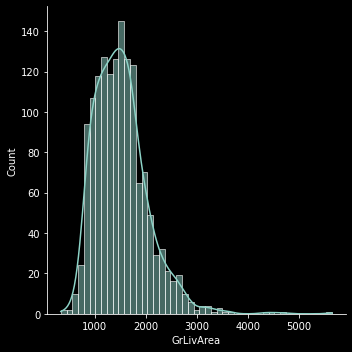

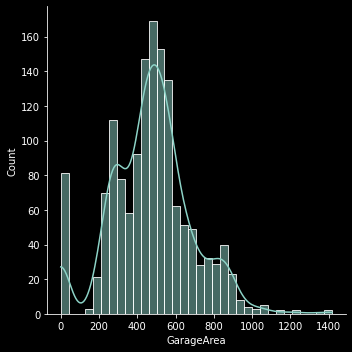

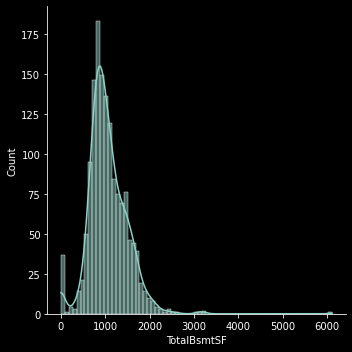

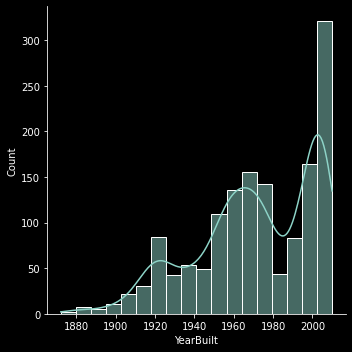

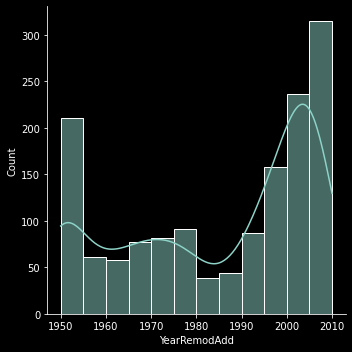

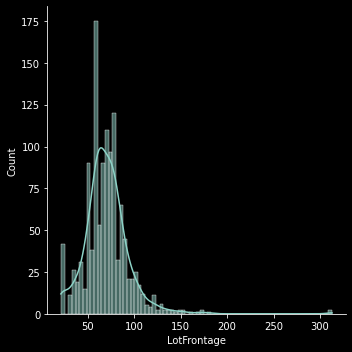

In [8]:
num_list = []
{num_list.append(k) for k, v in dict_cols.items() if v == "num" and k != "SalePrice" and k !="Id"}
for el in num_list:
    x = el
    sns.displot(data=df_sliced, x=x, kde=True)

Per le variabili categoriche è bene andare ad aggiungere un bar plot che ci permette di capire come sono distribuite tali variabili e se ci sono eventuali altri outliers. Per cui nella sezione successiva andiamo ad implementare proprio un plot di questo tipo

Le variabili categoriche del dataset sono le seguenti: ['OverallQual', 'GarageCars', 'FullBath', 'MSSubClass']


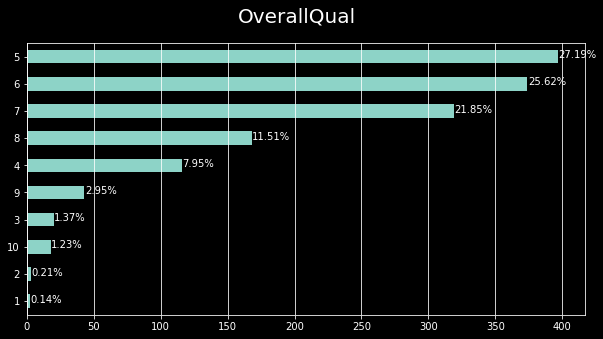

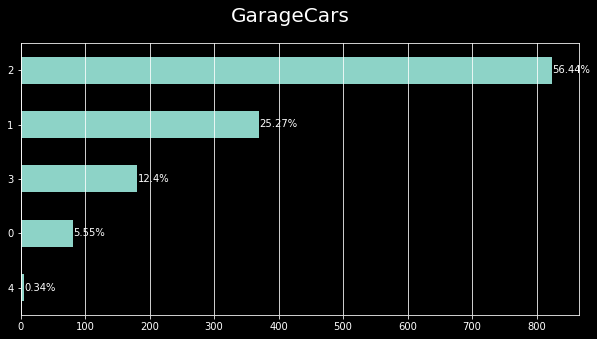

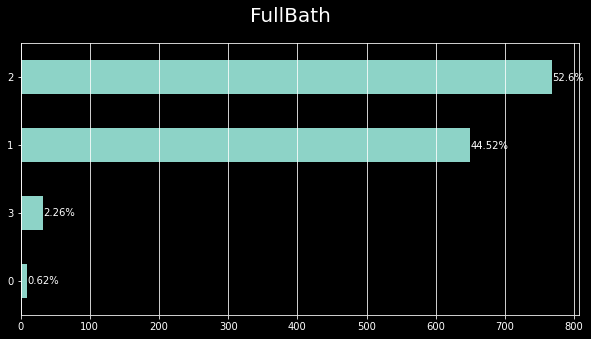

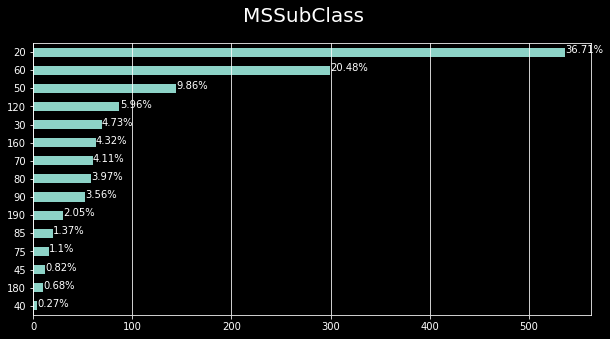

In [9]:
cat_list = []
{cat_list.append(k) for k, v in dict_cols.items() if v == "cat"}
print("Le variabili categoriche del dataset sono le seguenti: {}".format(cat_list))

for el in cat_list:
    x = el
    axs = df_sliced[x].value_counts().sort_values().plot(kind="barh")
    totals= []
    for i in axs.patches:
        totals.append(i.get_width())
        total = sum(totals)
    for i in axs.patches:
        axs.text(i.get_width()+.3, i.get_y()+.20, 
        str(round((i.get_width()/total)*100, 2))+'%', 
        fontsize=10, color='white')
    axs.grid(axis="x")
    plt.style.use("dark_background")
    plt.suptitle(x, fontsize=20)
    plt.show()

Possiamo capire da questo plot che molte delle case che sono nel nostro dataset hanno o uno o due bagni,  poi ci sono degli outliers su 0 e 3 bagni, in particolare la cosa importante da capire è se queste variabili categoriche hanno un potere regressivo per il prezzo, per cui dobbiamo passare a studiare il caso della distribuzione multivariata.
Possiamo quindi procedere in questo modo:
- ___Split della popolazione___: La dividiamo in quattro categorie principali a seconda del numero di bagni che sono presenti all'interno del nostro dataset
- ___Plot e confronto della densità___: andiamo a plottare le funzioni di densità di probabilità della variabile categorica, se le distribuzioni sono differenti allora la variabile ___FullBath___ ha potere predittivo, in quanto abbiamo pattern diversi di distribuzione
- ___Raggruppare le variabili numeriche___: Raggruppiamo le variabili numeriche, nel nostro caso il prezzo di vendita in intervalli e andiamo a plottare la composizione di ogni intervallo, se la proporzione della variabile categoriche è simile in ogni intervallo allora possiamo dire che non è predittiva.
- ___Plot dei box___: Studiamo il comportamento degli outliers andando a plottare i boxplot 


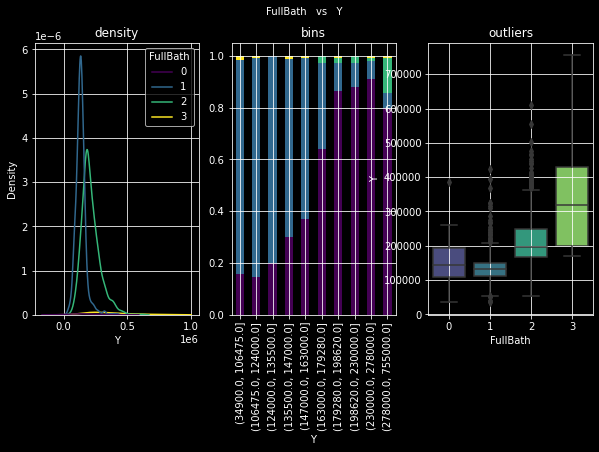

In [10]:
cat, num = "FullBath", "Y"
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(cat+"   vs   "+num, fontsize=10)
            
### distribution
ax1.title.set_text('density')
sns.kdeplot(data=df_sliced, x=num, palette=palette, hue=cat, ax=ax1)
ax1.grid(True)
### stacked
ax2.title.set_text('bins')
breaks = np.quantile(df_sliced[num], q=np.linspace(0,1,11))
tmp = df_sliced.groupby([cat, pd.cut(df_sliced[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df_sliced[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax2, legend=False, grid=True,colormap=palette)
### boxplot   
ax3.title.set_text('outliers')
sns.boxplot(x=cat, y=num, data=df_sliced, ax=ax3,palette=palette)
ax3.grid(True)
plt.show()


Dai dati che abbiamo analizzato sembra che la correlazione ci sia, in quanto le distribuzioni analizzate sono profondamente diverse. Ma quando non vogliamo fidarci dell'analisi solo osservando i dati possiamo fare una analisi apriori detta ___ANOVA___ ovvero (ANalysis Of VAriance), che ci permette di capire attraverso il _p value_ se esiste una correlazione tra le variabili. Nel caso dei bagni delle case sembra essere anche intuitivo, poichè da come vediamo nelle distribuzioni una maggiore quantità di bagni corrisponde ad una maggiore superificie della casa quindi possiamo dire che sono altamente correlate le variabili. Estendiamo il ragionamento a tutte le variabili categoriche che abbiamo nel dataset, cosi da capire quali sono correlate e quali no.

In [11]:
for el in cat_list:
    cat, num = el, "Y"
    model = smf.ols(num+' ~ '+cat, data=df_sliced).fit()
    table = sm.stats.anova_lm(model)
    p = table["PR(>F)"][0]
    coeff, p = None, round(p, 3)
    conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
    print("Anova F: the variables", el ," are", conclusion, "(p-value: "+str(p)+")")    


Anova F: the variables OverallQual  are Correlated (p-value: 0.0)
Anova F: the variables GarageCars  are Correlated (p-value: 0.0)
Anova F: the variables FullBath  are Correlated (p-value: 0.0)
Anova F: the variables MSSubClass  are Correlated (p-value: 0.001)


Finita l'analisi delle variabili categoriche passiamo a quella delle variabili numeriche, possiamo impostare il nostro studio basandoci su due plot fondamentalmente:
- ___Raggruppa e compara___: Possiamo raggruppare le variabili numeriche in bins e andare a confronatre il valore medio di Y in ogni intervallo. Se l'andamento per ogni bins ha pattern diversi allora potremmo dire che la variabile numerica è predittiva
- ___Scatterplot___: Scatter plot con le distribuzioni.

Le variabili numeriche del dataset sono le seguenti: ['GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'LotFrontage']


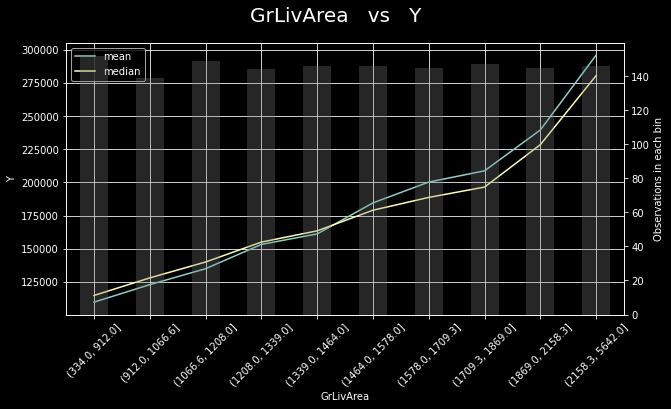

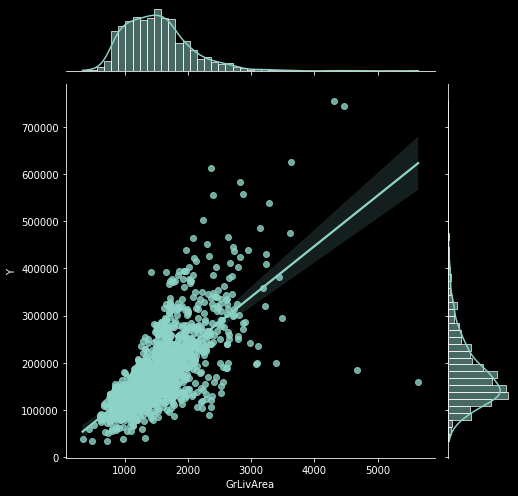

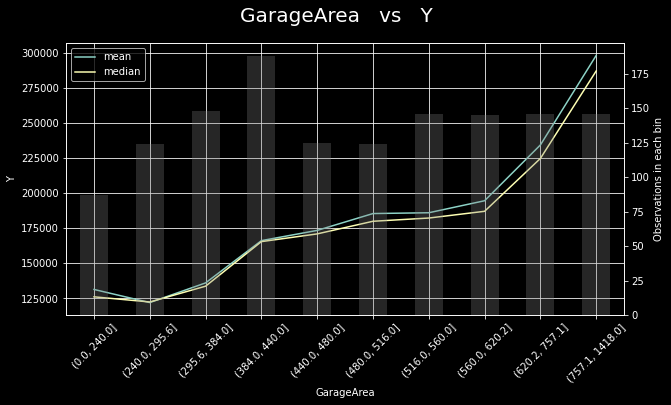

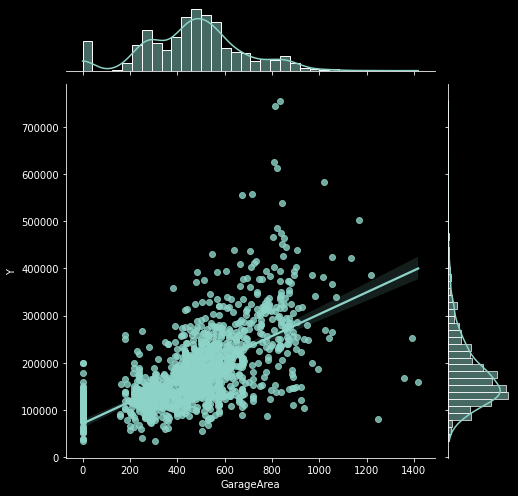

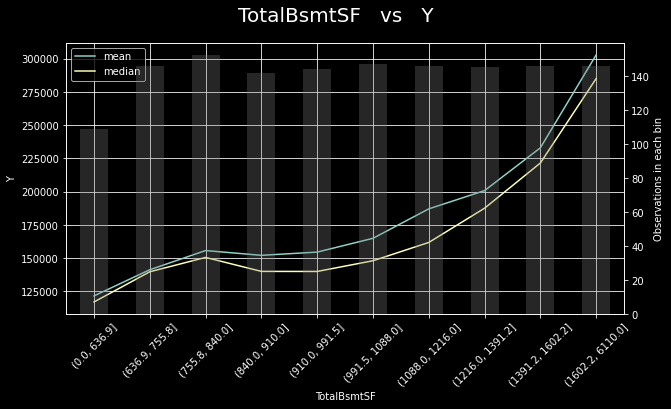

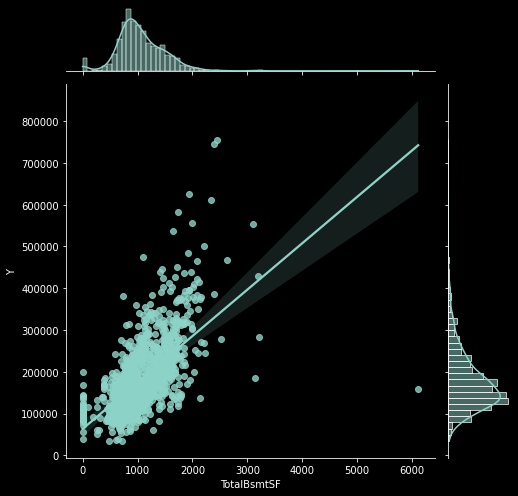

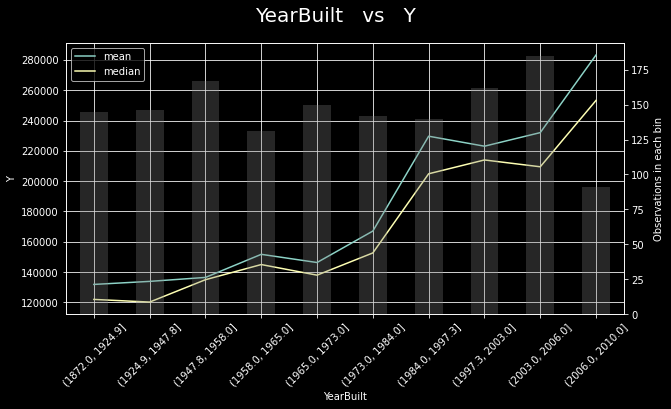

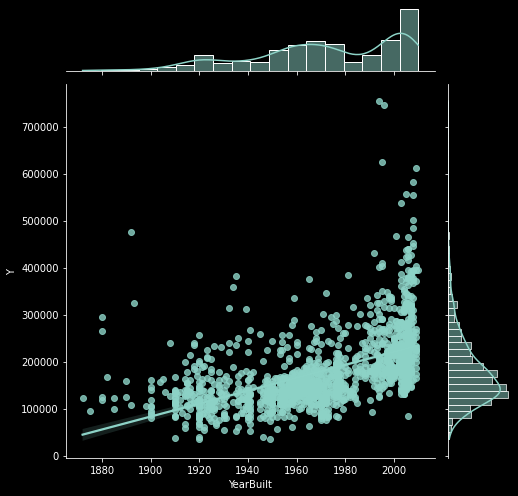

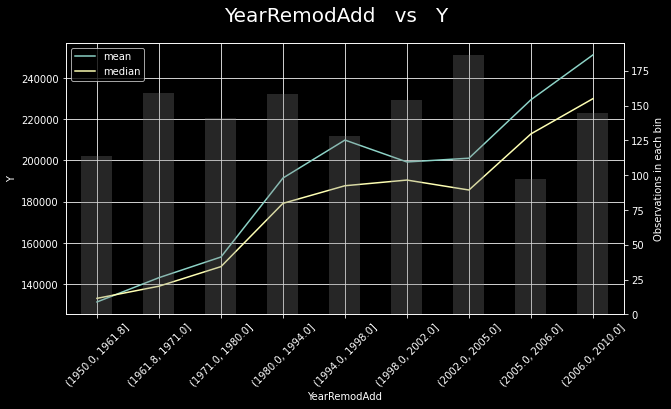

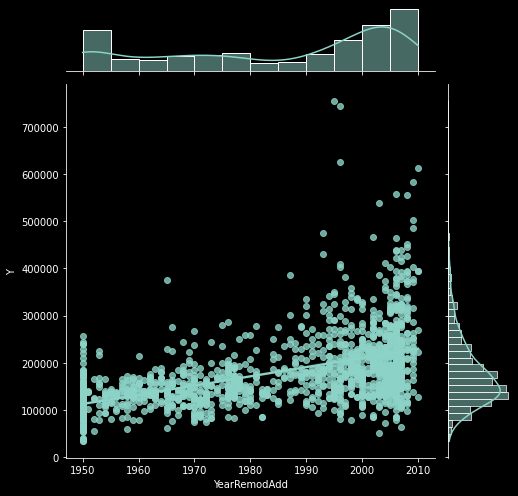

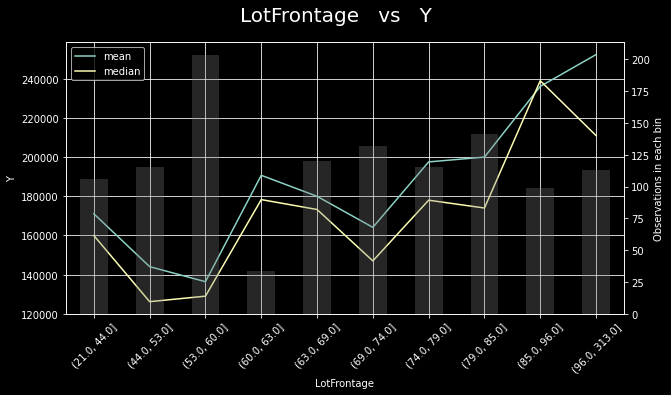

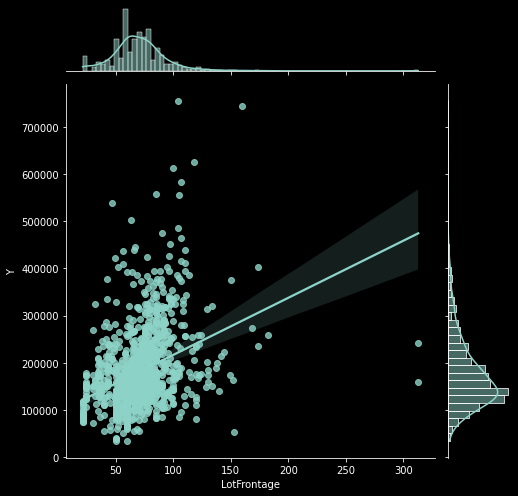

In [12]:
num_list = []
{num_list.append(k) for k, v in dict_cols.items() if v == "num" and k != "SalePrice" and k !="Id"}
print("Le variabili numeriche del dataset sono le seguenti: {}".format(num_list))
figsize = (10,5)

for el in num_list:
    x, y = el, "Y"
    dtf_noNan = df_sliced[df_sliced[x].notnull()]
    breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
    groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, 
               duplicates='drop')])[y].agg(['mean','median','size'])
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(x+"   vs   "+y, fontsize=20)
    groups[["mean", "median"]].plot(kind="line", ax=ax)
    groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                        color="grey", alpha=0.3, grid=True)
    ax.set(ylabel=y)
    ax.right_ax.set_ylabel("Observations in each bin")
    plt.show()
    sns.jointplot(x=x, y=y, data=df_sliced, dropna=True, kind='reg',height=int((figsize[0]+figsize[1])/2) )
    plt.show()

I plot sopra indicati dicono che le variabili potrebbero essere correlate tra loro, ma per andare a sfatare ogni dubbio possiamo andare a effettuare un test delle ipotesi di Pearson. Possiamo dire che attraverso questo test andiamo a misurare la correlazione che esiste tra due variabili di tipo continuo. E' importante sottolineare che la correlazione che viene misurata con questo coefficiente è solo di tipo lineare.

In [13]:
for el in num_list:

    x, y = el, "Y"
    coeff, p = scipy.stats.pearsonr(dtf_noNan[x], dtf_noNan[y])
    coeff, p = round(coeff, 3), round(p, 3)
    conclusion = "Significant" if p < 0.05 else "Non-Significant"
    print("Pearson Correlation of {}: ".format(el), coeff, conclusion, "(p-value: "+str(p)+")")

Pearson Correlation of GrLivArea:  0.704 Significant (p-value: 0.0)
Pearson Correlation of GarageArea:  0.632 Significant (p-value: 0.0)
Pearson Correlation of TotalBsmtSF:  0.627 Significant (p-value: 0.0)
Pearson Correlation of YearBuilt:  0.539 Significant (p-value: 0.0)
Pearson Correlation of YearRemodAdd:  0.519 Significant (p-value: 0.0)
Pearson Correlation of LotFrontage:  0.352 Significant (p-value: 0.0)


Nel dataset che abbiamo analizzato fino a questo momento abbiamo visto una classe che è MSS che ha 15 categorie, quindi andiamo a ridurre il numero di queste categorie a 3 creando dei cluster che sono, max, min e mean, cioè li andiamo a raggruppare per prezzo.
E' stato scelto un cluster gerarchico in quanto la distribuzione dei dati non è sferica, per cui risultava poco ottimizzato utilizzare l'algoritmo KMeans, in quanto quest'ultimo lavora bene quando i dati sono distrbuiti secondo una forma sferica in cui risulta facile andare a ricavare il centroide


/var/folders/lh/0_j5t9c16ls6cl4l26c5c9d00000gn/T/ipykernel_77345/3383720819.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster["labels_a"] = labels_a


1


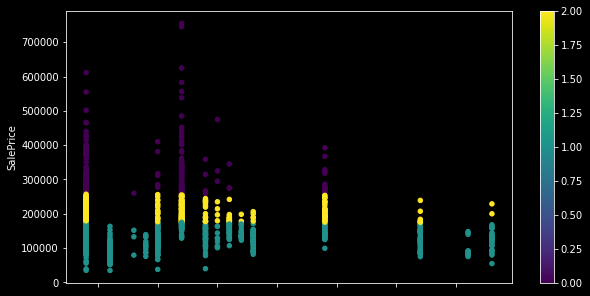

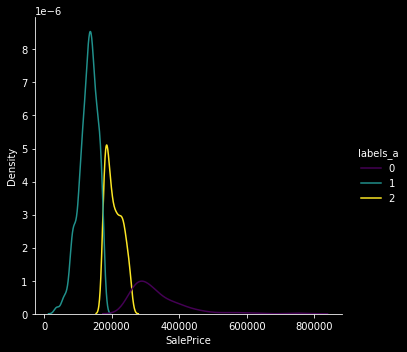

In [14]:
cols_cluster = ["MSSubClass", "SalePrice"]
df_cluster = df_complete[cols_cluster]
agg = AgglomerativeClustering(n_clusters=3)
df_cluster.head()
a = agg.fit(df_cluster)
labels_a = a.labels_
df_cluster.plot.scatter("MSSubClass", "SalePrice", c=labels_a, colormap=palette)
df_cluster["labels_a"] = labels_a
sns.displot(data=df_cluster, x="SalePrice",kind="kde",hue="labels_a",palette=palette)
df_sliced["MSSubClass"] = labels_a
print(df_sliced["MSSubClass"][df_sliced.index[-1]])

## DATA PREPROCESSING

Siamo quindi arrivati alla parte di data preprocessing che possiamo suddividere in differenti fasi così riassunte:

- ___Split del dataset___: Il dataset deve essere splittato in modo da avere, nella condizione più semplice dei dati di test e dei dati di train, per cui la prima azione che andremo a compiere è suddividere secondo una determinata proporzione i nostri dati. Possiamo dire in generale che ogni riga del nostro dataset rappresenterà un'_osservazione_ mentre ogni colonna rappresenta un _Features_.
- ___Analisi dei valori___: Come sappiamo nessun dataset è perfetto per cui, prima di andare a utilizzare i nostri dati è bene capire se ci sono dei dati mancanti o NaN e andarli a sostituire con qualche altro dato.
- ___Encoding dei dati categorici e data scaling___: I dati categorici hanno bisogno di essere encodati in quanto alcune variabili non hanno nessun significato se prese singolarmente. Inoltre è buona pratica andare a scalare i dati secondo una delle logiche utili a questo compito


In [15]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(df_sliced, 
                      test_size=0.3)
## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

X_train shape: (1022, 10) | X_test shape: (438, 10)
y_train mean: 180444.3 | y_test mean: 182033.94
11 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'LotFrontage', 'MSSubClass']


Passiamo adesso all'analisi dei missing data, in modo da capire quali sono le colonne che hanno dei dati mancanti e li andiamo a sostituire con qualche altro valore, come la media.


In [16]:
features = dtf_train.columns.to_list()
for el in features:
    s = df_sliced[el].isna().sum()
    percent = round((s*100)/(len(df_sliced.index)),2)
    print("la colonna {} ha {} NaN [{} %]".format(el,s,percent))


la colonna OverallQual ha 0 NaN [0.0 %]
la colonna GrLivArea ha 0 NaN [0.0 %]
la colonna GarageCars ha 0 NaN [0.0 %]
la colonna GarageArea ha 0 NaN [0.0 %]
la colonna TotalBsmtSF ha 0 NaN [0.0 %]
la colonna FullBath ha 0 NaN [0.0 %]
la colonna YearBuilt ha 0 NaN [0.0 %]
la colonna YearRemodAdd ha 0 NaN [0.0 %]
la colonna LotFrontage ha 259 NaN [17.74 %]
la colonna MSSubClass ha 0 NaN [0.0 %]
la colonna Y ha 0 NaN [0.0 %]


Dall'analisi sopra effettuata vediamo come l'unica variabile ad avere NaN è LotFrontage con 259 count che equivalgono al 17.74% del numero di osservazioni. Per cui su questa variabile sarà effetuata una sostituzione.

In [17]:
dtf_train["LotFrontage"] = dtf_train["LotFrontage"].fillna(dtf_train["LotFrontage"].mean())
dtf_train.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,Y
Id,,,,,,,,,,,
708,8,1324,2,550,1324,2,2006,2006,48.0,2,254000
452,7,1533,2,576,1533,2,1975,1975,62.0,0,280000
1203,5,1348,1,216,884,1,1925,1997,50.0,1,117000
1160,6,1876,2,540,901,2,1974,1974,76.0,2,185000
836,4,1067,2,436,1067,2,1950,1995,60.0,1,128000


Negli algoritmi di ML è sempre utile andare a scalare il dataset sia dal lato degli input sia dal lato delle variabili di target. Per fare questo andiamo ad utilizzare la funzione scaler di ___Scikit___. In particolare andiamo ad utilizzare il robustScaler, funzione di scikit che va a rimuovere la mediama e la scala, nel IQR.

In [18]:
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", 
                        axis=1).columns, index=dtf_train.index)
## scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dtf_scaled["Y"] = scalerY.fit_transform(
                    dtf_train["Y"].values.reshape(-1,1))
dtf_scaled.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,Y
Id,,,,,,,,,,,
708,1.0,-0.223425,0.0,0.295846,0.673010,0.0,0.691099,0.351351,-1.221026,1.0,1.087952
452,0.5,0.099729,0.0,0.401216,1.091637,0.0,0.041885,-0.486486,-0.443248,-1.0,1.401205
1203,-0.5,-0.186316,-1.0,-1.057751,-0.208312,-1.0,-1.005236,0.108108,-1.109915,0.0,-0.562651
1160,0.0,0.630073,0.0,0.255319,-0.174261,0.0,0.020942,-0.513514,0.334530,1.0,0.256627
836,-1.0,-0.620796,0.0,-0.166160,0.158237,0.0,-0.481675,0.054054,-0.554359,0.0,-0.430120


Arrivati a questo punto la cosa importante è andare a selezionare quali sono le features importanti per il nostro modello di ML, in particolar modo dobbiamo segliere features che vadano a prevenire il fenomeno di overfitting. 

Text(0.5, 1.0, 'pearson correlation')

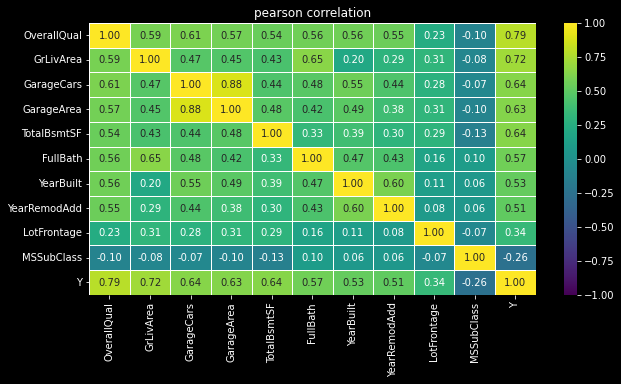

In [19]:
corr_matrix = dtf_train.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap=palette, cbar=True, linewidths=0.5)
plt.title("pearson correlation")

In particolare possiamo vedere dalla matrice di correlazione che sia _GrLivArea_ sia _GarageCars_ sono altamente correlate tra loro in maniera lineare, quindi andiamo a fare una scelta tra quale delle due debba essere tenuto all'interno del modello di ML. Solitamente quando ci si trova in una situazione di questo tipo si va a selezionare la variabile con il _p-value_ più basso. Il problema che si presenta nel nostro caso viene definito problema di ___multicollinearity___ e per risolverlo dobbiamo effettuare una attenta scelta di features. Il problema sopra descritto va ad affilgere la stima dei predittori della regressione per cui deve necessariamente essere risolto. Per fare questo sono stati messi a punto molte metodologia, come ___Tikhonov regularization___ anche detta __RIDGE__


<AxesSubplot:xlabel='selection', ylabel='features'>

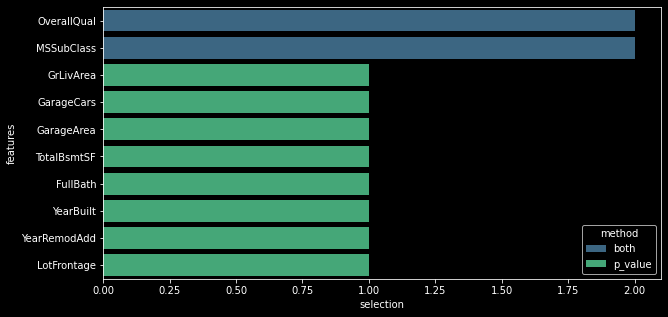

In [20]:
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns
## p-value
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_regression, k=10).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.Ridge(alpha=1.0, fit_intercept=True), 
                                 max_features=10).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]
 
## plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["p_value"] = dtf_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
dtf_features["regularization"] = dtf_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
dtf_features["method"] = dtf_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
dtf_features["method"] = dtf_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False, palette=palette)

Per avere un'altra idea dell'importanza delle features possiamo utilizzare i metodi di ensable che ci permettono di capire quali sono le featurs che bisogna selezionare. Questi metodi utilizzano modelli multipli per avere in uscita una migliore prestazione predittiva rispetto ai modelli presi singolarmente.

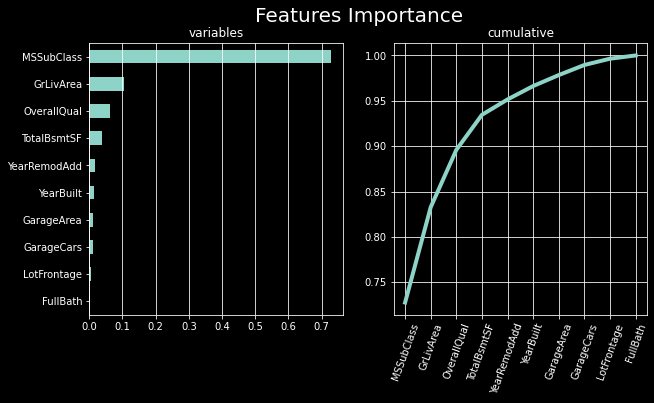

In [21]:
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns.tolist()
## call model
model = ensemble.GradientBoostingRegressor()
## Importance
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

Selezioniamo quindi le features di nostro interesse dati anche i risultati delle analisi fatte in precedenza

In [22]:
X_names = ['OverallQual', 'GrLivArea', 'MSSubClass', "GarageCars", "TotalBsmtSF"]
X_train = dtf_train[X_names].values
y_train = dtf_train["Y"].values

## MODEL DESIGN
Andiamo a selzionare un semplice modello regressivo e ad utilizzare come metrica __R squared__. Per la validazione invece abbiamo utilizzato un metodo chiamato K-fold, che va a splittare il dataset in n sotto cartelle che vengono utilizzate per il train e per il test.

--------------------------------------------------
MEAN R2 scores 0.7831681723463192 with linear regression: 
--------------------------------------------------


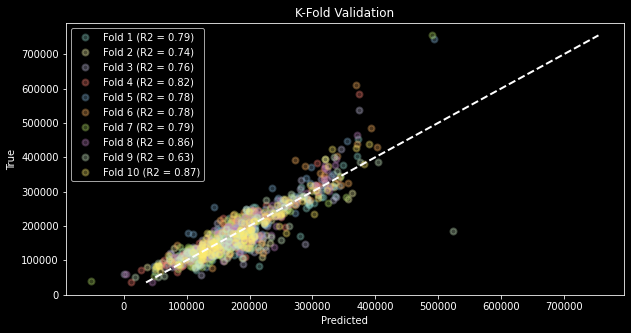

In [23]:
## call model
model = linear_model.LinearRegression()
## K fold validation
scores = []
cv = model_selection.KFold(n_splits=10, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='white')
print(50*"-")
print("MEAN R2 scores {} with linear regression: ".format(mean(scores)))
print(50*"-")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()


--------------------------------------------------
MEAN R2 scores 0.8920938069564085 with Gradient Boost: 
--------------------------------------------------


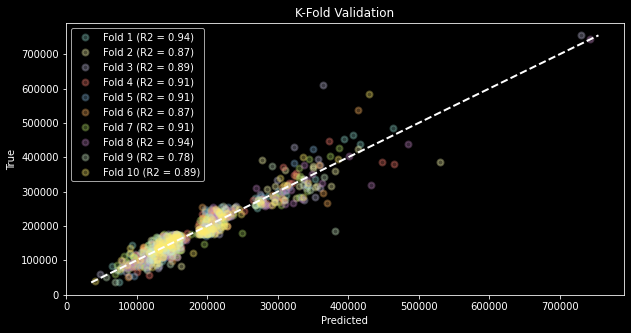

In [24]:
model_boost = ensemble.GradientBoostingRegressor()
## K fold validation
scores = []
cv = model_selection.KFold(n_splits=10, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model_boost.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='white')
print(50*"-")
print("MEAN R2 scores {} with Gradient Boost: ".format(mean(scores)))
print(50*"-")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()


Come possiamo notare il gradient boost ha una performance migliore nella predizione quindi da questo punto in poi porteremo lui avanti come modello per andare a predirre i prezzi dal datset di test. Quindi andiamo a ripetere il processo di preprocess sul nostro dataset di test.

In [25]:
features = dtf_test.columns.to_list()
for el in features:
    s = dtf_test[el].isna().sum()
    percent = round((s*100)/(len(dtf_test.index)),2)
    print("la colonna {} ha {} NaN [{} %]".format(el,s,percent))

dtf_test["LotFrontage"] = dtf_test["LotFrontage"].fillna(dtf_test["LotFrontage"].mean())
dtf_test.head()


scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(dtf_test.drop("Y", axis=1))
dtf_scaled_test= pd.DataFrame(X, columns=dtf_test.drop("Y", 
                        axis=1).columns, index=dtf_test.index)
## scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dtf_scaled_test["Y"] = scalerY.fit_transform(dtf_test["Y"].values.reshape(-1,1))
dtf_scaled_test.head()


X_test = dtf_train[X_names].values
y_test = dtf_train["Y"].values

la colonna OverallQual ha 0 NaN [0.0 %]
la colonna GrLivArea ha 0 NaN [0.0 %]
la colonna GarageCars ha 0 NaN [0.0 %]
la colonna GarageArea ha 0 NaN [0.0 %]
la colonna TotalBsmtSF ha 0 NaN [0.0 %]
la colonna FullBath ha 0 NaN [0.0 %]
la colonna YearBuilt ha 0 NaN [0.0 %]
la colonna YearRemodAdd ha 0 NaN [0.0 %]
la colonna LotFrontage ha 73 NaN [16.67 %]
la colonna MSSubClass ha 0 NaN [0.0 %]
la colonna Y ha 0 NaN [0.0 %]


Andiamo ad effettuare quindi la predizione utilizzando come modello quello trainati con il gradient boost

In [26]:
predicted = model_boost.predict(X_test)

utilizziamo come metriche di paragone del modello l' R_squared e successivamente alcuni errori come RMSE e MAE che ci permettono di avere informazioni relative alla qualità totale della regressione che abbiamo implementato.

In [27]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predicted)/predicted)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))
## residuals
residuals = y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.95
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.08
Mean Absolute Error (Σ|y-pred|/n): 13,211
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 17,530
Max Error: 152,985


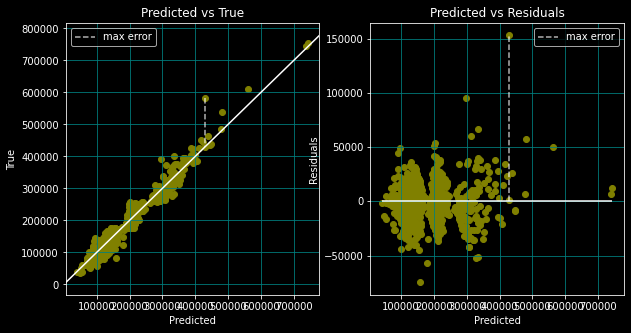

In [28]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
from statsmodels.graphics.api import abline_plot
ax[0].scatter(predicted, y_test, color="olive")
abline_plot(intercept=0, slope=1, color="white", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='white', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True, c="teal")
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
## Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="olive")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='white', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True, c="teal")
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

vediamo da questi plot come il massimo errore sia di circa 216k, mentre i residui sembrano concentrarsi su un valore che oscilla intorno ai 50k, andiamo però ad osservarne la distribuzione.

/Users/mariovozza/opt/anaconda3/envs/AI_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


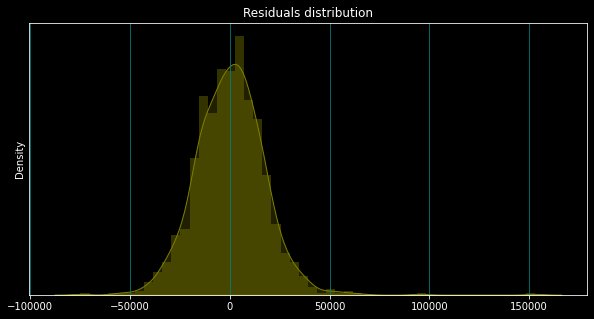

In [29]:
fig, ax = plt.subplots()
sns.distplot(residuals, color="olive",hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True, c="teal")
ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
plt.show()